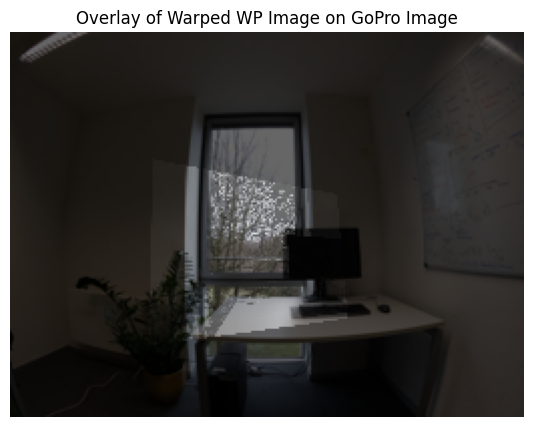

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the GoPro .dng image
gopro_image = cv2.imread('gopro10photo_20230310T0930.dng', cv2.IMREAD_UNCHANGED)
gopro_image_rgb = cv2.cvtColor(gopro_image, cv2.COLOR_BGR2RGB)

# Read and process the WP .csv data
with open('mcone_2.csv', 'r', encoding='utf-8-sig') as file:
    data_str = file.read().replace(';', '.')
with open('temp_mcone.csv', 'w') as file:
    file.write(data_str)
mcone_data = np.loadtxt('temp_mcone.csv', delimiter=',')
mcone_normalized = (255 * (mcone_data - np.min(mcone_data)) / (np.max(mcone_data) - np.min(mcone_data))).astype(np.uint8)
mcone_rgb = cv2.cvtColor(mcone_normalized, cv2.COLOR_GRAY2RGB)

# Resize the WP image for SIFT processing
resized_mcone_rgb = cv2.resize(mcone_rgb, (mcone_rgb.shape[1] // 2, mcone_rgb.shape[0] // 2))

# Initialize SIFT and detect keypoints for both images
sift = cv2.SIFT_create()
gopro_keypoints, gopro_descriptors = sift.detectAndCompute(gopro_image_rgb, None)
mcone_keypoints, mcone_descriptors = sift.detectAndCompute(resized_mcone_rgb, None)

# Match the keypoints between the two images
bf = cv2.BFMatcher()
matches = bf.knnMatch(gopro_descriptors, mcone_descriptors, k=2)

# Filter out poor matches using the ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Estimate the transformation matrix using RANSAC
src_pts = np.float32([gopro_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([mcone_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp the WP image to align with the GoPro image using the inverse homography
inv_matrix = np.linalg.inv(matrix)
warped_wp = cv2.warpPerspective(resized_mcone_rgb, inv_matrix, (gopro_image_rgb.shape[1], gopro_image_rgb.shape[0]))

# Overlay the warped WP image on the GoPro image
overlay_alpha = 0.6
overlay_img = cv2.addWeighted(gopro_image_rgb, 1 - overlay_alpha, warped_wp, overlay_alpha, 0)

# Display the overlay image
plt.figure(figsize=(10, 5))
plt.imshow(overlay_img)
plt.axis('off')
plt.title("Overlay of Warped WP Image on GoPro Image")
plt.show()
